## Homework 4.1: Ramachandran plots from molecular dynamics (10 pts)

In this homework set, you will be using the molecular dynamics (MD) functionality of TRIAD, a physics-based computational protein design platform. Make a [Triad account](https://triad.protabit.com/signup) using your Caltech email address. Indicate that you are a non-commercial free user.

From the [landing page](https://triad.protabit.com/dashboard), navigate to "Applications/Modeling/Molecular Dynamics." Upload A_capped.pdb as the Input structure. This file contains alanine that has “capped” amine and carbonyl groups so the residue behaves as if it were part of a protein. Set the PDB output period to 10. With this period, TRIAD will output a structure file every 10 steps in the MD simulation. 

Under "3-Score function configuration" select Rosetta with covalent terms. Under "4-Optimization protocol settings," set the Schedule as "50. 300. 300. 100000." Submit your job. Once the job finishes, you'll receive an email. From the job output, download the peptide_designed_steps.pdb file and save it to the same directory as this .ipynb file. 

Repeat these steps for G_capped.pdb and P_capped.pdb before running the code below.

Run through the following code blocks to extract $\phi$ and $\psi$ angles from each step in each MD simulation. Ramachandran plots will be generated.
<hr>

In [2]:
import Bio.PDB
import bokeh.io
import bokeh.plotting
import glob
import math
import numpy as np
import os
import pandas as pd
import warnings

bokeh.io.output_notebook()

Loading BokehJS ...

Instantiate data frame to store $\phi$ and $\psi$ angles.

In [3]:
df = pd.DataFrame(columns=['step', 'residue', 'phi', 'psi'])

Define residue name dictionary.

In [4]:
aa_dict = {'G': 'GLY', 'A': 'ALA', 'P': 'PRO'}

Generate Ramachandran plot from *_capped_steps.pdb files. No modifications to the code below are necessary.

In [5]:
aa_str = 'GAP'

for res in aa_str:
    file_name = res + '_capped_steps.pdb'
    
    with open(file_name, 'r') as f:
        f_list = f.readlines()
        
    # Find lines corresponding to each snapshot in the MD simulation.
    step_line_idx = []
    end_line_idx = []
    step_nums = []

    for i in range(len(f_list)):
        line = f_list[i]

        if 'REMARK' in line:

            step_num = line[6:line.find('derivatives')-1].replace(' ','')
            step_nums.append(step_num)


            new_file_lines = []
            new_file_lines.append(line)

            step_line_idx.append(i)

        else:
            new_file_lines.append(line)

            if 'END' in line:
                end_line_idx.append(i)
    
    # Write lines corresponding to each snapshot to separate files.
    for i, end_line in enumerate(end_line_idx):
        line_count = step_line_idx[i]

        new_file_name = './steps/' + file_name[0:file_name.find('.') - 1] + '_' + step_nums[i] + '.pdb'
        os.makedirs(os.path.dirname(new_file_name), exist_ok=True)

        with open(new_file_name, 'w') as f_out:
            while line_count <= end_line:
                f_out.write(f_list[line_count])
                line_count += 1
                
    # Get list of snapshot files
    file_list = glob.glob(new_file_name[0:new_file_name.find('step_') + 4] + '_' + '*' + '.pdb')
    
    # Store phi and psi aangles for each step
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for file_name in file_list:
            step = file_name[file_name.find('step_') + 5:file_name.find('.pdb')]

            for model in Bio.PDB.PDBParser().get_structure("pept", file_name):

                for chain in model:
                    polypeptides = Bio.PDB.PPBuilder().build_peptides(chain)

                    for poly_index, poly in enumerate(polypeptides):
                        phi_psi = poly.get_phi_psi_list()

                        for res_index, residue in enumerate(poly):
                            if (res_index == 1) and (residue.resname == 'ALA' or residue.resname == 'GLY' or residue.resname == 'PRO'):
                                phi = phi_psi[res_index][0]
                                psi = phi_psi[res_index][1]
                                new_row_dict = {'step': [int(step)], 'residue': [residue.resname], 
                                                'phi': [np.rad2deg(float(phi))], 'psi': [np.rad2deg(float(psi))]}
                                df = pd.concat([df, pd.DataFrame.from_dict(new_row_dict)], ignore_index = True)
                
    # Make Ramachandran plot
    p = bokeh.plotting.figure(
        width=400,
        height=350,
        x_axis_label="𝜙 (°)",
        y_axis_label="𝜓 (°)",
        title="MD Ramachandran plot for " + aa_dict[res],
        x_range=[-180, 180],
        y_range=[-180, 180]
    )

    p.circle(
        source=df.loc[df['residue'] == aa_dict[res]],
        x="phi",
        y="psi",
        color="blue",
        alpha=0.5
    )
    
    bokeh.io.show(p)

Compare the simulated Ramachandran plots you generated and give some reasons for the differences. 
<hr>

The simulated Ramachandran plots help visualize the energetically allowed conformations of $\phi$ and $\psi$ angles in peptides. Glycine has the most allowed confomationis because it has the smallest group (H) attachd to the $\alpha$ carbon. Larger groups hinder rotations so alanine and proline amino acids have fewer allowed confirmations. In the case of the alanine, a amine group limits the rotation between $100-200\degree$ and $-170- -200\degree$ for $\psi$ and only allows for negative rotations in the $\phi$ angle. Proline is the most restricted amino acid because of its 5-member ring.

Compare your Ramachandran plots obtain from simulating the amino acids to Ramachandran plots found in the literature (see lecture on protein stability) and give some reasons for the differences. Visualizing the structures provided in PyMOL could be beneficial. You can install PyMOL [here](https://pymol.org/2/). A license is not required for the analysis done in this assignment.
<hr>

The simulated Ramdachandran plots have fewer allowed conformations that the empirically derived plots. This is because the "capping" over constrains the allowed rotations (viewed with Pymol) compared to a true residue. In a real protein, the capping would occur linearly on the ends and not bridge across the molecule.

![Screenshot 2023-12-03 at 1.57.03 PM.png](<attachment:Screenshot 2023-12-03 at 1.57.03 PM.png>)

<br />
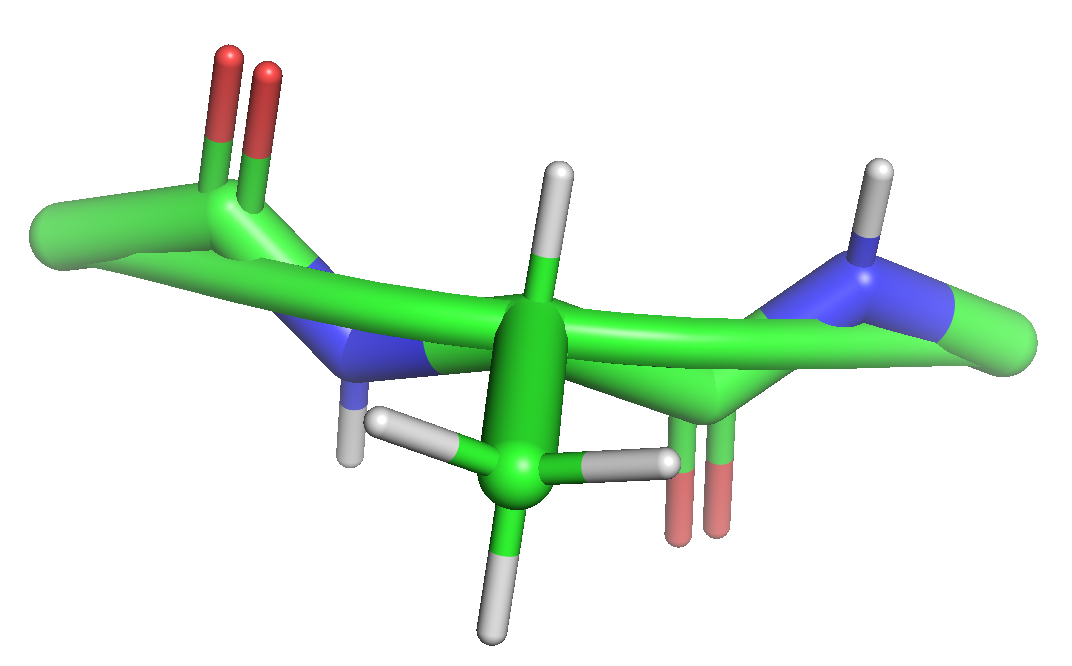